In [1]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load tokenizer and model
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_embedding_chemberta_77(smiles):
    with torch.no_grad():
        inputs = tokenizer(smiles, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        attention_mask = inputs['attention_mask']     # [batch_size, seq_len]

        # Expand attention_mask to match token_embeddings dimensions
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

        # Perform mean pooling excluding padding tokens
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
        sum_mask = input_mask_expanded.sum(dim=1).clamp(min=1e-9)
        embedding = sum_embeddings / sum_mask

        return embedding.detach().numpy().flatten()

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import pandas as pd
data = pd.read_csv('CycPeptMPDB_Peptide_All.csv', low_memory=False)

In [3]:
print(f"Initial number of rows: {len(data)}")
print(f'# of Columns before dropping: {data.shape[1]}')
data = data.drop_duplicates(subset='Structurally_Unique_ID')
print(f"Number of rows after dropping duplicate molecules: {len(data)}")

Initial number of rows: 8466
# of Columns before dropping: 247
Number of rows after dropping duplicate molecules: 7991


In [4]:
# Remove columns with any missing values
data = data.dropna(axis=1)
print(f"Number of columns after dropping those with missing values: {data.shape[1]}")
print(f"Columns remaining: {data.columns.tolist()}")

# Remove Permeabiltiy = -10
data = data[data['Permeability'] != -10]
print(f"Number of rows after removing Permeability = -10: {len(data)}")

Number of columns after dropping those with missing values: 226
Columns remaining: ['ID', 'Source', 'Year', 'Version', 'Original_Name_in_Source_Literature', 'Structurally_Unique_ID', 'SMILES', 'HELM', 'HELM_URL', 'Sequence', 'Sequence_LogP', 'Sequence_TPSA', 'Monomer_Length', 'Monomer_Length_in_Main_Chain', 'Molecule_Shape', 'Permeability', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', '

In [5]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

y = data['Permeability']

# Multithreaded embedding generation for ChemBERTa-77M-MTR
def get_emb_chemberta_77_thread(smiles):
    return get_embedding_chemberta_77(smiles)

with ThreadPoolExecutor() as executor:
    embeddings_chemberta_77 = list(tqdm(executor.map(get_emb_chemberta_77_thread, data['SMILES']), total=len(data), desc="Generating ChemBERTa-77M embeddings"))

Generating ChemBERTa-77M embeddings: 100%|██████████| 7718/7718 [00:22<00:00, 338.87it/s]


In [6]:
print(f"Initial number of rows of Permeability: {len(y)}")
print(f"Number of embeddings for ChemBERTa-77M: {len(embeddings_chemberta_77)}")

Initial number of rows of Permeability: 7718
Number of embeddings for ChemBERTa-77M: 7718


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_array = y.to_numpy()

# Train a Random Forest model using ChemBERTa-77M embeddings
X_chemberta_77 = np.stack(embeddings_chemberta_77)
X_train_77, X_test_77, y_train_77, y_test_77 = train_test_split(X_chemberta_77, y_array, test_size=0.2, random_state=42)

rf_chemberta_77 = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_chemberta_77.fit(X_train_77, y_train_77)

y_pred_77 = rf_chemberta_77.predict(X_test_77)

mae_77 = mean_absolute_error(y_test_77, y_pred_77)
rmse_77 = np.sqrt(mean_squared_error(y_test_77, y_pred_77))
r2_77 = r2_score(y_test_77, y_pred_77)

print(f"ChemBERTa-77M RF MAE: {mae_77:.4f}")
print(f"ChemBERTa-77M RF RMSE: {rmse_77:.4f}")
print(f"ChemBERTa-77M RF R2: {r2_77:.4f}")

ChemBERTa-77M RF MAE: 0.3924
ChemBERTa-77M RF RMSE: 0.5321
ChemBERTa-77M RF R2: 0.5554


In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gbm_77 = GradientBoostingRegressor(random_state=42)
gbm_77.fit(X_train_77, y_train_77)
y_pred_gbm_77 = gbm_77.predict(X_test_77)

mae_gbm_77 = mean_absolute_error(y_test_77, y_pred_gbm_77)
rmse_gbm_77 = np.sqrt(mean_squared_error(y_test_77, y_pred_gbm_77))
r2_gbm_77 = r2_score(y_test_77, y_pred_gbm_77)

print(f"ChemBERTa-77M Gradient Boosting MAE: {mae_gbm_77:.4f}")
print(f"ChemBERTa-77M Gradient Boosting RMSE: {rmse_gbm_77:.4f}")
print(f"ChemBERTa-77M Gradient Boosting R2: {r2_gbm_77:.4f}")


ChemBERTa-77M Gradient Boosting MAE: 0.4167
ChemBERTa-77M Gradient Boosting RMSE: 0.5581
ChemBERTa-77M Gradient Boosting R2: 0.5110


In [12]:
print(f"data shape: {data.shape}")
print(f"X_chemberta_77 shape: {X_chemberta_77.shape}")
print(f"X_train_77 shape: {X_train_77.shape}")
print(f"X_test_77 shape: {X_test_77.shape}")
print(f"y shape: {y.shape}")
print(f"y_array shape: {y_array.shape}")
print(f"y_train_77 shape: {y_train_77.shape}")
print(f"y_test_77 shape: {y_test_77.shape}")
print(f"y_pred_77 shape: {y_pred_77.shape}")
print(f"y_pred_gbm_77 shape: {y_pred_gbm_77.shape}")

data shape: (7718, 226)
X_chemberta_77 shape: (7718, 384)
X_train_77 shape: (6174, 384)
X_test_77 shape: (1544, 384)
y shape: (7718,)
y_array shape: (7718,)
y_train_77 shape: (6174,)
y_test_77 shape: (1544,)
y_pred_77 shape: (1544,)
y_pred_gbm_77 shape: (1544,)


ChemBERTa-77M MLP MAE: 0.3841
ChemBERTa-77M MLP RMSE: 0.5195
ChemBERTa-77M MLP R2: 0.5763


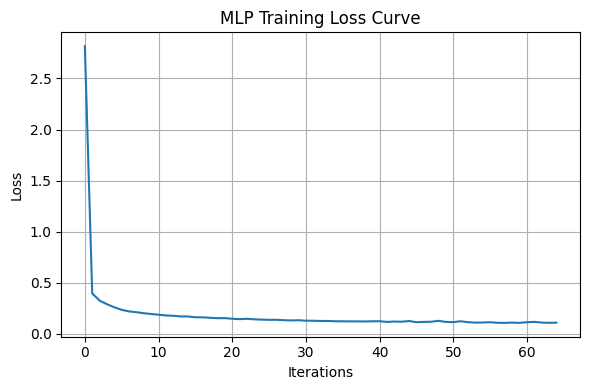

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Build and train a deeper MLP with early stopping
mlp_77 = MLPRegressor(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False
)

mlp_77.fit(X_train_77, y_train_77)

# Predict and evaluate
y_pred_mlp_77 = mlp_77.predict(X_test_77)
mae_mlp_77 = mean_absolute_error(y_test_77, y_pred_mlp_77)
rmse_mlp_77 = np.sqrt(mean_squared_error(y_test_77, y_pred_mlp_77))
r2_mlp_77 = r2_score(y_test_77, y_pred_mlp_77)

print(f"ChemBERTa-77M MLP MAE: {mae_mlp_77:.4f}")
print(f"ChemBERTa-77M MLP RMSE: {rmse_mlp_77:.4f}")
print(f"ChemBERTa-77M MLP R2: {r2_mlp_77:.4f}")

# Plot training loss curve
plt.figure(figsize=(6, 4))
plt.plot(mlp_77.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
